In [121]:
using Distributions
using Random
import PyPlot; plt=PyPlot
using LaTeXStrings
using Printf
plt.rc("figure", dpi=150.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=150.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

We'll simulate data $(X_1, X_2)$ from their prior distributions:
\begin{equation}
    \begin{split}
        X_1 &\sim \mathcal{N}(0, 1) \\
        X_2 &\sim \mathcal{N}(4, 1) \\
    \end{split}
\end{equation}

In [122]:
prior1 = Normal(0, 1)
prior2 = Normal(4, 1)

Random.seed!(1) # set the random seed
x1, x2 = rand(prior1), rand(prior2) # obtain random draws from the priors
max12 = max(x1, x2) # we observe the maximum of the two 
x1, x2, max12

(0.2972879845354616, 4.3823959677906075, 4.3823959677906075)

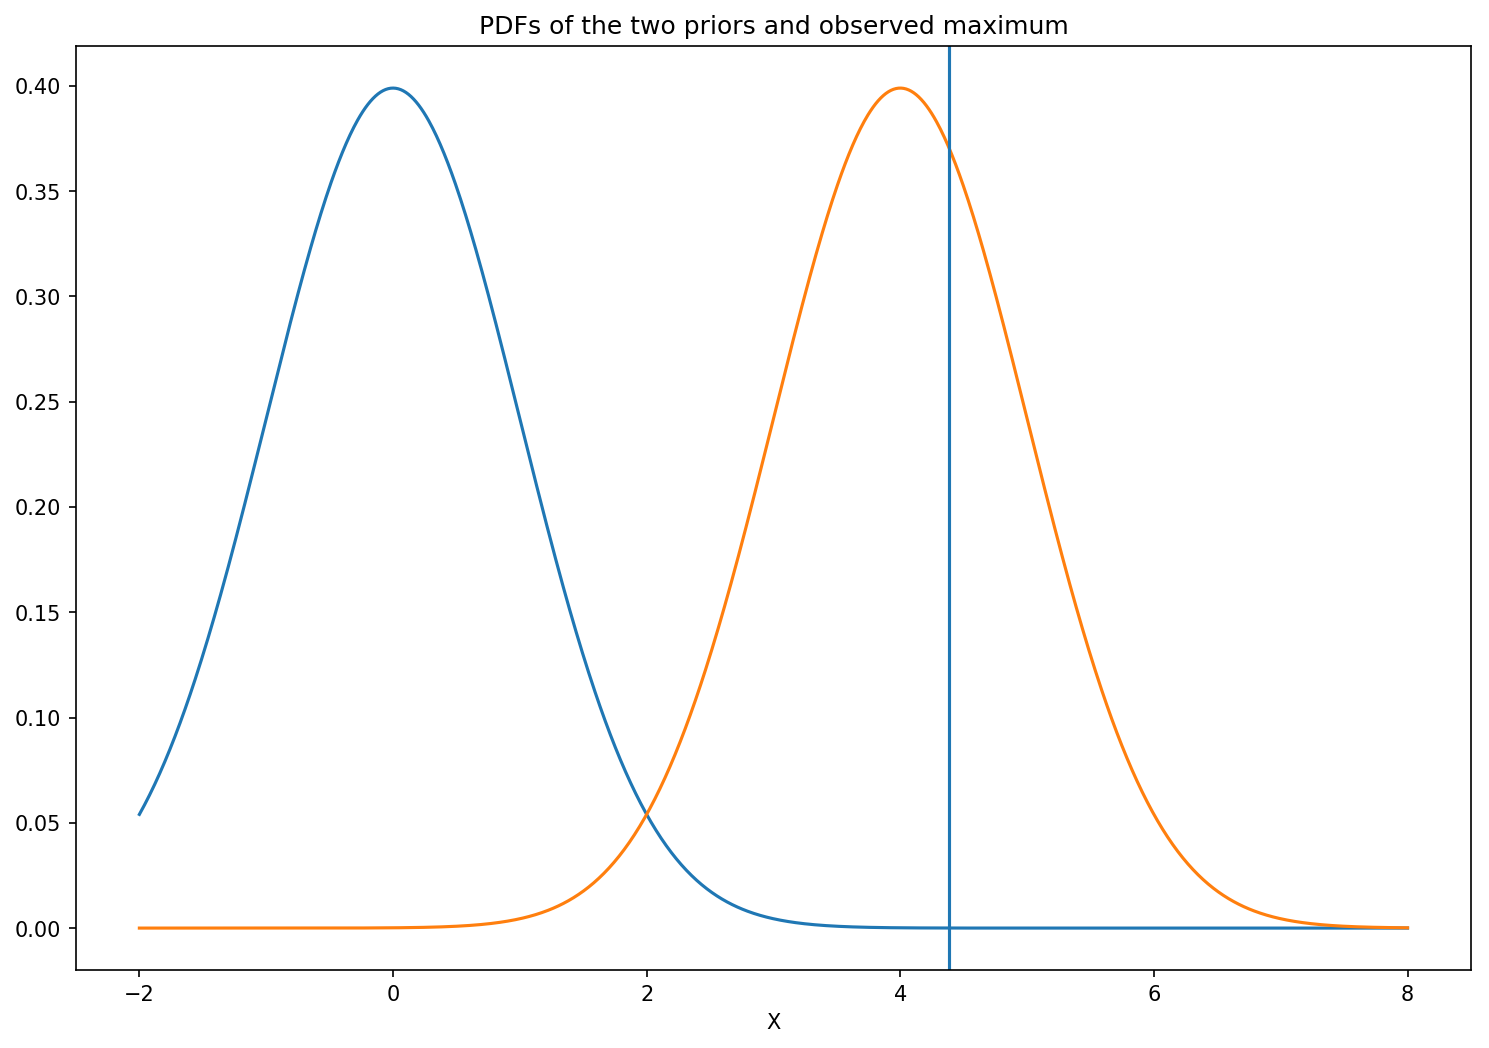

In [123]:
xx = range(-2, stop=8, length=1000)
plt.plot(xx, pdf.(prior1, xx))
plt.plot(xx, pdf.(prior2, xx))
plt.axvline(max12)
plt.xlabel("X")
plt.title("PDFs of the two priors and observed maximum")
;

In [124]:
"""
    Compute the posterior mean given the prior of X₁ and X₂
    and the observed max(x₁, x₂).
"""
function posterior_mean(prior1, prior2, max12)
    # probability that the maximum was set by X₁ (proportional to)
    p1ismax = pdf(prior1, max12) * cdf(prior2, max12)
    p2ismax = pdf(prior2, max12) * cdf(prior1, max12)
    # distribution of X₂ if X₁ set the maximum:
    p2_if_1max = TruncatedNormal(mean(prior2), std(prior2), -Inf, max12)
    p1_if_2max = TruncatedNormal(mean(prior1), std(prior1), -Inf, max12)
    # mean of X₁ and X₂ if X₁ set the maximum:
    mean_if_1max = (max12+mean(p2_if_1max))/2
    mean_if_2max = (max12+mean(p1_if_2max))/2
    # the posterior mean is a weighted average of the two scenarios:
    post_mean = (p1ismax*mean_if_1max + p2ismax*mean_if_2max) / (p1ismax+p2ismax)
#     posterior_var = (p1ismax*var(p2_if_1max) + p2ismax*var(p1_if_2max)) / (p1ismax+p2ismax)
    return post_mean
end
posterior_mean(prior1, prior2, max12)

2.191265347327446

In [125]:
# That was one simulation. Now let's do 10000.
nsim = 100_000
errors_vec = zeros(nsim)
for isim in 1:nsim
    # obtain random draws from the priors
    local x1, x2 = rand(prior1), rand(prior2)
    true_mean = (x1+x2)/2
    local max12 = max(x1, x2) 
    # compute the posterior mean given the correct priors and the observed max
    post_mean = posterior_mean(prior1, prior2, max12)
    # compute and store the error:
    error = post_mean - true_mean
    errors_vec[isim] = error
end

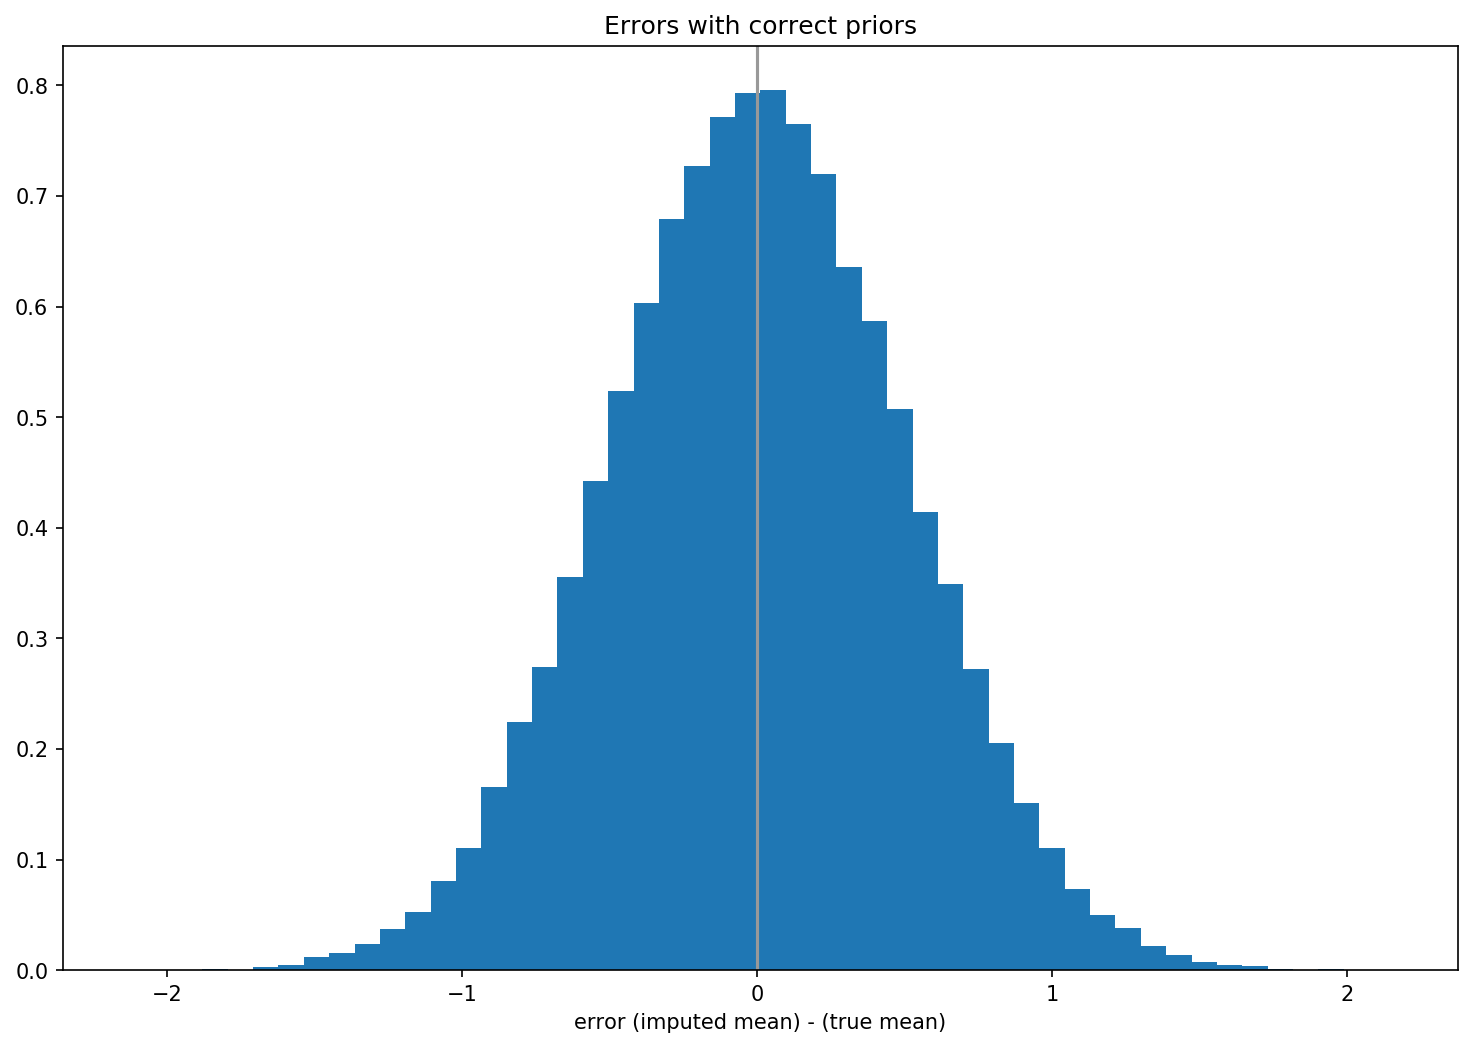

(0.0027172885602531243, 0.499331851004899)

In [126]:
plt.plt[:hist](errors_vec, bins=50, normed=true)
plt.axvline(0.0, color="#999999")
plt.title("Errors with correct priors")
plt.xlabel("error (imputed mean) - (true mean)")
mean(errors_vec), std(errors_vec)

But now let's see what happens if we triple the standard deviation of the priors for posterior inference but not for simulation.

In [127]:
inflated_prior1 = Normal(mean(prior1), std(prior1)*3)
inflated_prior2 = Normal(mean(prior2), std(prior2)*3)
nsim = 100_000
inflated_errors_vec = zeros(nsim)
for isim in 1:nsim
    local x1, x2 = rand(prior1), rand(prior2)
    true_mean = (x1+x2)/2
    local max12 = max(x1, x2) 
    post_mean = posterior_mean(inflated_prior1, inflated_prior2, max12)
    error = post_mean - true_mean
    inflated_errors_vec[isim] = error
end

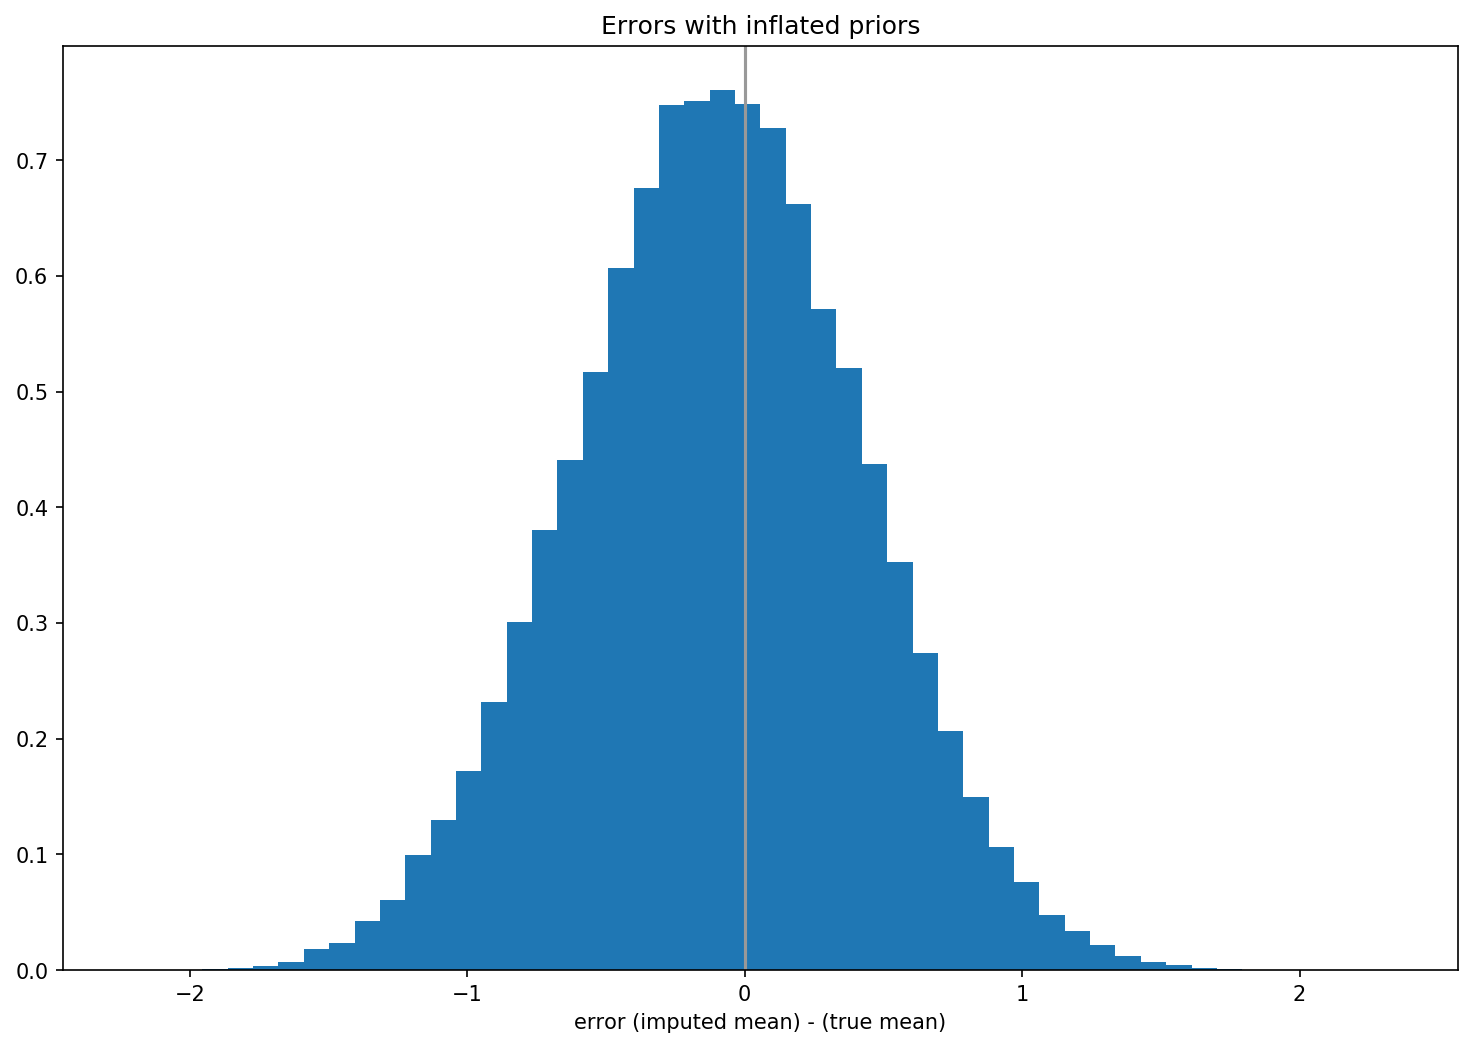

(-0.09751225410372037, 0.5167114673052192)

In [128]:
plt.plt[:hist](inflated_errors_vec, bins=50, normed=true)
plt.axvline(0.0, color="#999999")
plt.title("Errors with inflated priors")
plt.xlabel("error (imputed mean) - (true mean)")
mean(inflated_errors_vec), std(inflated_errors_vec)

In this example the bias is negative. But this shows that an inflated prior in the first stage can cause a bias in the second stage.